In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [6]:
def plot_ddos(df: pd.DataFrame):
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    # Create a figure
    fig = plt.figure(figsize=(25,15))
    # Add a subplot
    ax = fig.add_subplot()

    ax.plot(xAxis, yAxis)
    rect = Rectangle((7200, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((3600*3 + 7200 +280, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    plt.ylabel('Label')
    plt.xlabel('Minute')
    plt.title('Network Traffic')
    plt.show()

In [30]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

data_path = '../verisetleri/ddos_dataset_on_seconds.csv'
syn_benign_df = upload_dataset_with_time(data_path)

Dataset is loaded in 0.11258908299987525 seconds


In [9]:
ntp_path = '../verisetleri/ntp_by_seconds_data.csv'
ntp_df = upload_dataset_with_time(ntp_path)

Dataset is loaded in 0.022799082999881648 seconds


In [16]:
def label_ddos(label:int):
    if label > 20:
        return 1
    else:
        return 0
ntp_df["Label"] = ntp_df["Label"].apply(lambda x: label_ddos(x))

In [21]:
ddos_ntp = ntp_df[ntp_df["Label"] == 1].sample(524).reset_index(drop=True)

In [38]:
ddos_ntp = ddos_ntp[[*(syn_benign_df.columns)]]

In [40]:
syn_slice_1 = syn_benign_df.iloc[:12000, :].copy()
syn_slice_2 = syn_benign_df.iloc[12000:, :].copy()
merged_df = pd.concat([syn_slice_1, ddos_ntp ,syn_slice_2], axis = 0).reset_index(drop=True)

In [43]:
df = merged_df.copy()

In [44]:
def select_samples_from_dataset(dataset : pd.DataFrame , samples : list):
    if (dataset.empty):
        raise ValueError("Dataset is None!")

    if (samples == None):
        raise ValueError("sample list is None")

    return dataset.iloc[samples, :]

In [45]:
from sklearn.metrics import classification_report
def calculate_classification_report(y_values_df : pd.DataFrame):
    if 'y_true' not in y_values_df.columns:
        raise ValueError('true vals not included in df')

    if 'y_pred' not in y_values_df.columns:
        raise ValueError('pred vals not included in df')

    return classification_report(y_values_df["y_true"].to_list(), y_values_df["y_pred"].to_list(), output_dict=True)["1"]

In [46]:
def obtain_y_vals(dataframe:pd.DataFrame, selected_label_list):
    df_idxs = list(range(0, len(dataframe)))
    for idx in selected_label_list:
        df_idxs.remove(idx)
    
    pred_df = pd.DataFrame()
    pred_df['y_true'] = dataframe["Label"].copy()
    pred_df["y_pred"] = dataframe["Label"].copy()
    
    pred_df.iloc[df_idxs, 0] = 0
    pred_df.iloc[selected_label_list, 0] = 1
    return pred_df

In [13]:
import stumpy
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 4

In [14]:
y = df[["Label"]]
X = df.drop(["Label"], axis = 1)

In [15]:
feature_map = {i : feat_name for i, feat_name in enumerate(X.columns)}
X.columns = list(range(0, len(X.columns)))

In [16]:
featureNumber = 5
genes = [random.randrange(0,2) for _ in range(featureNumber)]
gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
individual = X.iloc[:, gene_indexes]

In [17]:
window_size = 60
curr_mps, curr_indices = stumpy.mstump(individual, window_size)

In [22]:
individual

,2,4
0,5278085.0,1090202.0
1,3508037.0,771278.0
2,3365823.0,755249.0
3,5278085.0,1090202.0
4,3508037.0,771278.0
...,...,...
25671,3508037.0,771278.0
25672,3365823.0,755249.0
25673,5278085.0,1090202.0
25674,3508037.0,771278.0


In [23]:
#ileride sadece discord base mp_maximization kullanirsak ise yarayabilir.
import matrixprofile as mp
mp_mp = mp.compute(individual[2].to_list(),windows=60, n_jobs=4)
mp_mps, mp_pi = mp_mp['mp'], mp_mp['pi']
sorted_list = sorted(zip(mp_pi, mp_mps), key=lambda x:x[1], reverse=True)[:3]

In [24]:
curr_mps.shape

(2, 25617)

In [26]:
def calculate_discords(mps: np.array, individual:pd.DataFrame, window_size:int, discord_num:int=476):
    from collections import Counter
    curr_mps_dict = dict()
    curr_mps_dict = {f_idx: np.argsort(curr_mps[idx])[::-1][:500] for idx, f_idx in enumerate(individual.columns)}
    discords = {}
    for idx, indices in curr_mps_dict.items():
        print(f'now processing current idx: {idx}') 
        indice_list = []
        for indice in indices:
            #get mp point window
            indice_list.extend(list(range(indice, indice + window_size - 1)))
        #sort the indices by count
        sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
        sorted_discord_indexes = [elem[0] for elem in sorted_discords[:discord_num]]

        discords[idx] = sorted_discord_indexes
    return discords
        

In [27]:
def majority_vote_discords(discord_dict: dict, discord_number:int = 476):
    from collections import Counter
    overall_list = []
    for ft, ids_list in discord_dict.items():
        overall_list.extend(ids_list.copy())

    sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
    overall_ids = [elem[0] for elem in sorted_overall[:discord_number]]

    return overall_ids

In [28]:
discord_dict = calculate_discords(curr_mps, individual.copy(), window_size=window_size, discord_num=476)

now processing current idx: 2
now processing current idx: 4


In [29]:
discords = majority_vote_discords(discord_dict=discord_dict, discord_number=476)

In [30]:
y_vals = obtain_y_vals(df.copy(), discords)

In [31]:
calculate_classification_report(y_vals)['f1-score']

0.9978991596638656

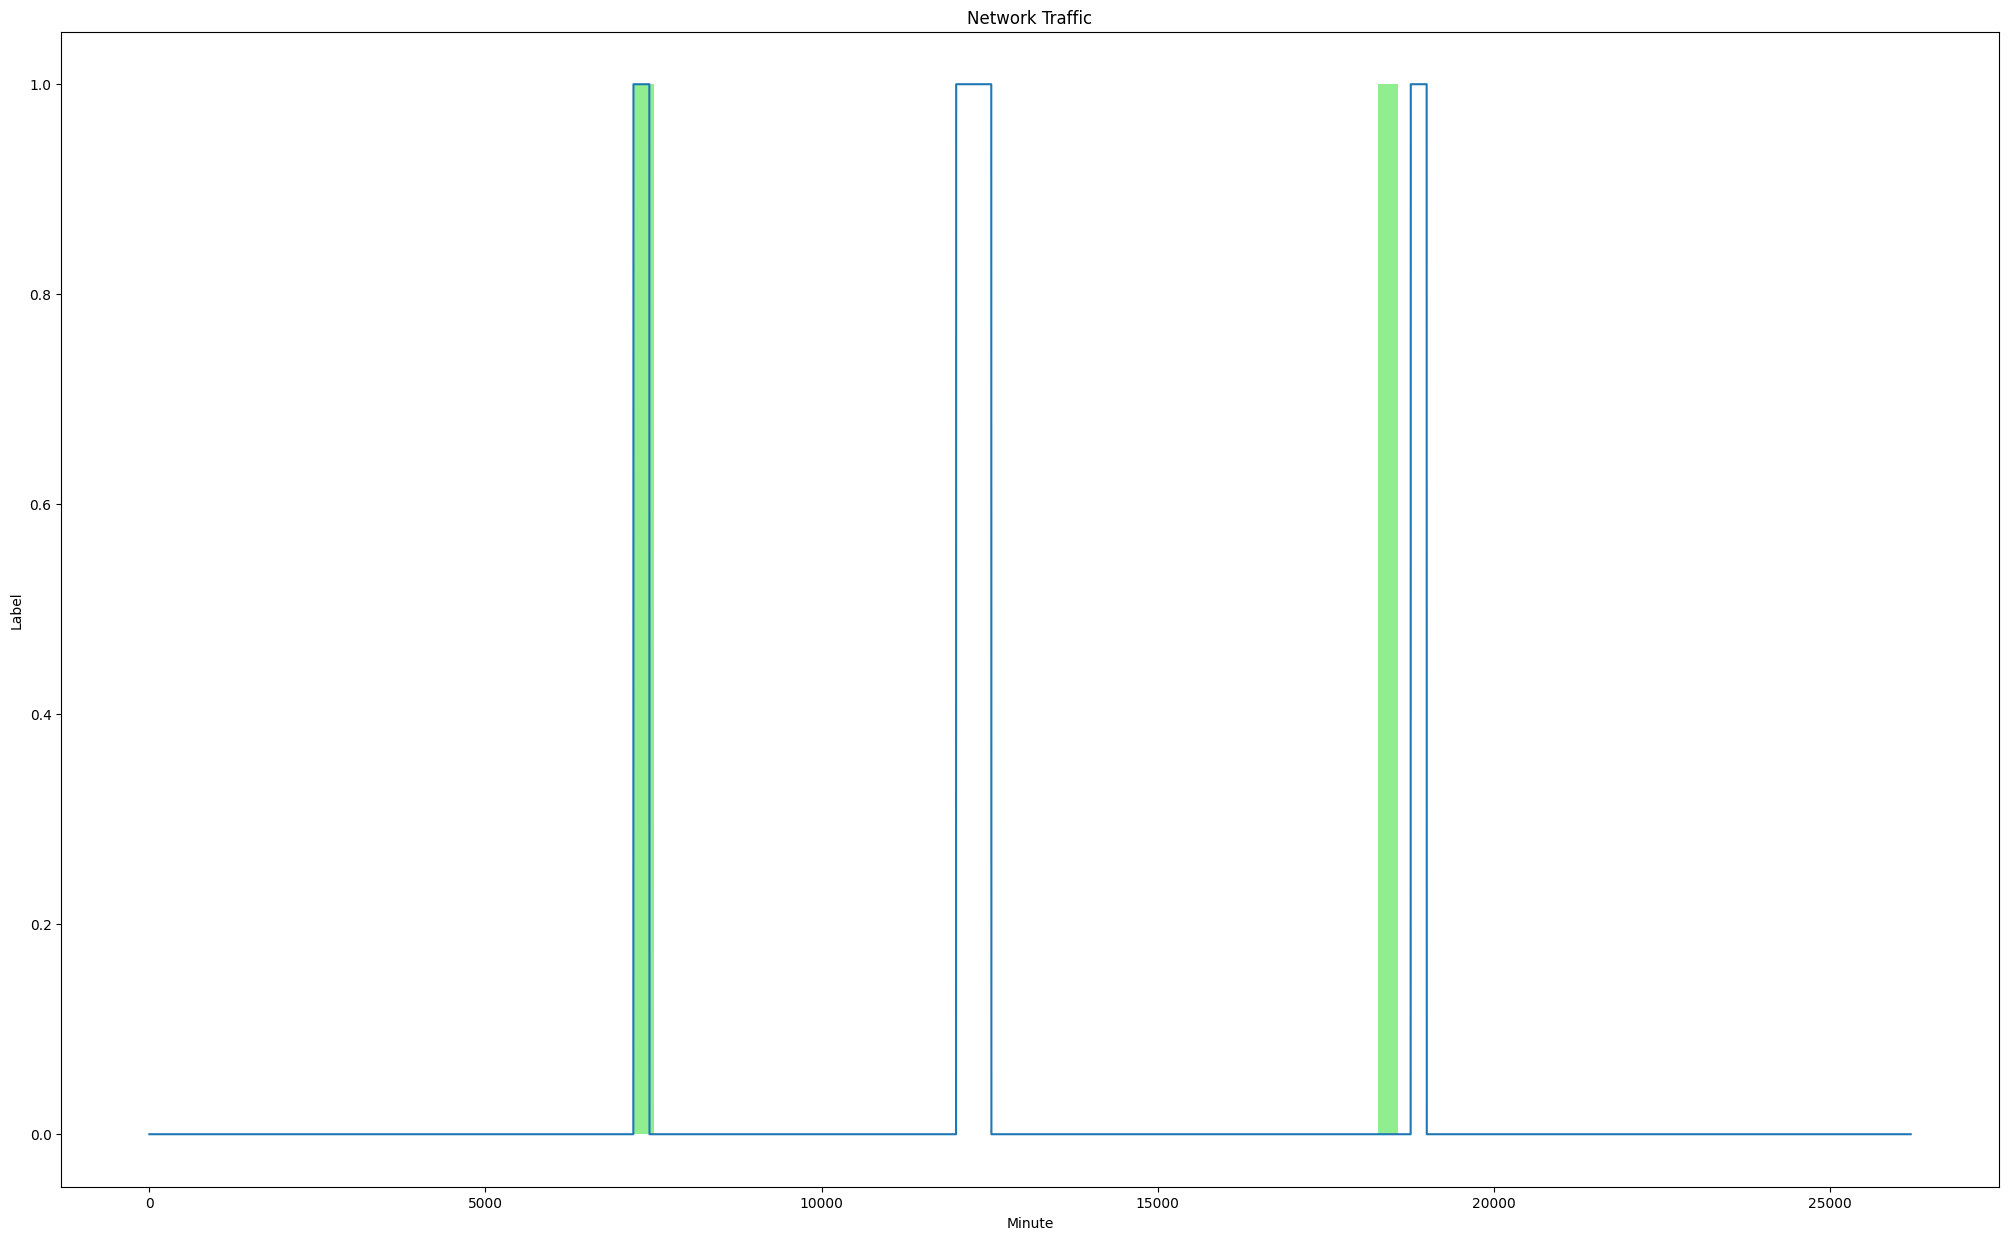

In [49]:
plot_ddos(df.copy())

In [204]:
import pandas as pd
import numpy as np
import stumpy
import random

class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = pd.read_csv('../verisetleri/ddos_dataset_on_seconds.csv', low_memory=True)

    THRESHOLD_BASE_ACTIVE = False
    threshold = 1.5

    def __init__(self, df:pd.DataFrame, window_size:int = 60, discord_number = 476, method='mpx', measure='acc'):
        self.measurement = measure
        self.window_size = window_size
        self.discord_number = discord_number
        self.discord_dict = {}
        self.discords = []
        self.df = df
        self.mp_method = method
        self.curr_mp_dict = {}

    def calculate_mp_multivariate_stumpy(self):
        curr_mps, curr_indices = stumpy.mstump(self.df, self.window_size)
        self.mps = curr_mps

    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
    
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:1000] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))
            #sort the indices by count
            sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
            sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes

    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list.copy())

        if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
            self.discords = list(set(overall_list)).copy()
            return

        sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
        self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]


    def obtain_y_vals(self):
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        for idx in self.discords:
            df_idxs.remove(idx)
  
        
        self.pred_df = pd.DataFrame()
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 0] = 0
        self.pred_df.iloc[self.discords, 0] = 1

    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        self.creport = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)["1"]

    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        return sum([sum(mp_score) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())

    def calculate_cost(self):
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score

    def calculate_thresholded_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        threshold = MatrixProfileManager.threshold
        curr_mps_dict = {f_idx: np.where(self.mps[idx] > threshold)[0].tolist() for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:10] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
                self.discord_dict[idx] = indice_list.copy()
            else:
                AssertionError("wrong func!")

    def calculate_threshold_based_cost(self):    
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()

        self.calculate_thresholded_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score

In [219]:
MatrixProfileManager.global_df = df.copy()

(83.23035341389235, 0.6386349786715417)


In [215]:

class GeneticAlgo:
    verbosity_level = 0
    def __init__(self, df:pd.DataFrame, max_features:int, population_bag_size:int = 3, fitness = 'MP'):
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(self.X.columns)}
        self.X.columns = list(range(0, len(self.X.columns)))
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.creport = None
        self.eval_result = None
        self.fitness_type = fitness
        

    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(self.X.iloc[:, gene_indexes])

        return self.population_bag

    def create_population(self, pop_bag) -> pd.DataFrame:
        self.population_bag.clear()
        for elem in pop_bag:
            self.population_bag.append(self.X.iloc[:, elem])
            
        return self.population_bag

    def fitness_function(self, individual:pd.DataFrame):
        mp_manager = MatrixProfileManager(individual, window_size=60, discord_number=1000, method='mpx', measure='mp')
        cost, f1_score = mp_manager.calculate_cost()
        if (GeneticAlgo.verbosity_level < 2):
            print(f'processing solution: {individual.columns.to_list()}')
            print(f"f1-score is: {mp_manager.get_f1_score()}")
        #return f1score instead of cost in order to maximize f1-score:
        
        # return cost, f1_score
        return cost, f1_score

    def eval_fit_population(self, pop_bag):
        #This evaluation is based on minimizing the cost!
        result = {}
        fit_vals_lst = []
        f1_score_lst = []
        solutions = []
        for individual in pop_bag:
            if (type(individual) != pd.DataFrame):
                assert(True)

            cost, f1_sc = self.fitness_function(individual.copy())
            fit_vals_lst.append(cost)
            f1_score_lst.append(f1_sc)
            solutions.append(individual.columns.to_list())
            
        result["fit_vals"] = fit_vals_lst
        result["f1-scores"] = f1_score_lst 
        if self.fitness_type == "MP":
            min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
        else:
            min_wgh = [abs(np.min(list(result['f1-scores'])) - i) for i in list(result['f1-scores'])]
        
        from scipy.special import logsumexp
        result["fit_wgh"]  = [i/logsumexp(min_wgh) for i in min_wgh]
        result["solution"] = np.array(solutions, dtype=list).tolist()
        
        self.eval_result = result.copy()
        return result

    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        f1_sc = eval_result["f1-scores"][best_fit_index]
        print(f'best fit: {best_fit}\nsolution: {best_solution}\nf1Score: {f1_sc}')
        return {'best_fit': best_fit, 'index' : best_fit_index,
                 'solution': best_solution, 'f1-score' : f1_sc}

    def pick_one(self, pop_bag):
        
        if self.eval_result is None:
            eval_result = self.eval_fit_population(pop_bag)
        else:
            eval_result = self.eval_result

        notPicked=True
        cnt = 0
        pickedSol = list()
        while (notPicked == True):
            rnIndex = random.randint(0, len(pop_bag)-1)
            rnPick  = eval_result["fit_wgh"][rnIndex]
            r = random.random()
            if  r <= rnPick:
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            if (cnt > 250):
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            cnt += 1

        return pickedSol

    def crossover(self, solA, solB):
        
        n     = len(solA)
        child: list = []

        num_els = random.randint(0, self.feature_number)
        str_pnt = random.randint(0, max(0,n-3))
        end_pnt = n if int(str_pnt+num_els) > n else int(str_pnt+num_els)

        blockA = list(solA[str_pnt:end_pnt])
        child = blockA.copy()

        for elem in solB:
            if len(child) >= num_els:
                break
            if elem not in blockA:
                child.append(elem)  

        if (len(child) < 1):
            return solA

        return child

    def mutation(self,sol):
        
        n = len(sol)
        pos_1 = random.randint(0,n-1)
        pos_2 = random.randint(0,n-1)
        result = self.swap(sol, pos_1, pos_2)
        return result

    def swap(self,sol, posA, posB):
        result = sol.copy()
        elA = sol[posA]
        elB = sol[posB]
        result[posA] = elB
        result[posB] = elA
        return result

## Imply Genetic Process with MP

In [216]:
import mp_genetic_utils
import pandas as pd




def func(generation_num:int=5, max_feat:int=20, pop_bag_size:int=10, fitness_type:str="MP"):
    import random as rnd
    GeneticAlgo.verbosity_level = 4
    genetic_algo = GeneticAlgo(df.copy(), max_features=max_feat, population_bag_size=pop_bag_size, fitness=fitness_type)
    pop_bag = genetic_algo.initialize_population()
    generation_number = generation_num
    for generation in range(generation_number):
        print(f"Generation {generation} is started!")
        
        res = genetic_algo.eval_fit_population(pop_bag)
        best_fit, _, best_solution, f1_score = genetic_algo.find_best(res).values()
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
        else:
            if (best_fit >= best_fit_global):
                best_fit_global      = best_fit
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(genetic_algo.population_bag)):
                # Pick 2 parents from the bag
            pA = genetic_algo.pick_one(pop_bag)
            pB = genetic_algo.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if rnd.random() <= 0.87:
                new_element = genetic_algo.crossover(pA, pB)
            # Mutate the child
            # if rnd.random() <= 0.7:
            #     new_element = mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = genetic_algo.create_population(new_pop_bag)

    print("\n\n**** Generations Over ****\n")
    print(f"Best Fitness: {best_fit_global}")
    print(f"Best Solution: {best_solution_global}")
    print(f"F1-Score: {f1_score}")


In [104]:
MatrixProfileManager.global_df = df.copy()
func(fitness_type="MP")

Genetic Algorithm Process is ready to start
Generation 0 is started!
best fit: 3580.4160764984167
solution: [1, 2, 5, 6, 7, 8, 11, 16, 17, 19]
f1Score: 0.937
Generation 1 is started!
best fit: 3658.6889976097445
solution: [15, 16, 19, 0, 1, 2, 6]
f1Score: 0.902
Generation 2 is started!
best fit: 3733.0474950371035
solution: [4, 5, 11, 12, 15, 16, 19, 0, 1, 2, 6]
f1Score: 0.936
Generation 3 is started!
best fit: 3733.047495037103
solution: [16, 19, 0, 1, 2, 6, 4, 5, 11, 12, 15]
f1Score: 0.914
Generation 4 is started!
best fit: 4061.484399021706
solution: [4, 5, 12, 15, 0, 2, 6, 16]
f1Score: 0.8769999999999999


**** Generations Over ****

Best Fitness: 4061.484399021706
Best Solution: [4, 5, 12, 15, 0, 2, 6, 16]
F1-Score: 0.8769999999999999


In [107]:
help(func)

Help on function func in module __main__:

func(generation_num: int = 5, max_feat: int = 20, pop_bag_size: int = 10, fitness_type: str = 'MP')



In [108]:
func(generation_num=20, max_feat=38, pop_bag_size=10, fitness_type="F1")

Genetic Algorithm Process is ready to start
Generation 0 is started!
best fit: 4287.18390427637
solution: [0, 4, 6, 7, 8, 9, 10, 14, 16, 17, 19, 21, 24, 27, 28, 29, 30, 31, 32, 33]
f1Score: 0.911
Generation 1 is started!
best fit: 4647.944506777544
solution: [15, 16, 19, 20, 21, 26, 27, 28, 32, 35, 36, 1]
f1Score: 0.7190000000000001
Generation 2 is started!
best fit: 4728.889181809727
solution: [23, 24, 25, 28, 32, 33, 36, 29, 31, 35]
f1Score: 0.861
Generation 3 is started!
best fit: 5613.526101977333
solution: [1, 4, 5, 6, 27]
f1Score: 0.933
Generation 4 is started!
best fit: 6179.841304820825
solution: [28, 32, 35, 36]
f1Score: 0.75
Generation 5 is started!
best fit: 5828.204952309163
solution: [28, 32, 33, 36, 29, 7, 8]
f1Score: 0.598
Generation 6 is started!
best fit: 6093.506316600381
solution: [25, 28, 32]
f1Score: 0.637
Generation 7 is started!
best fit: 4744.031902301571
solution: [5, 6]
f1Score: 0.524
Generation 8 is started!
best fit: 5019.651260697574
solution: [37, 0, 11, 1

In [160]:
np.where(mp_mng.mps[4] > 1.5)[0].shape
discords = np.where(mp_mng.mps[4] > 5)[0].tolist()

In [158]:
sum(df.iloc[discords, -1])

95

In [218]:
batu_discords = (np.argsort(mp_mng.mps[4])[::-1][:1000]).tolist()

In [146]:
sum(df.iloc[batu_discords, -1]) / 1000

0.919

In [234]:
import pandas as pd
import numpy as np
import stumpy
import random

class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = pd.read_csv('../verisetleri/ddos_dataset_on_seconds.csv', low_memory=True)

    THRESHOLD_BASE_ACTIVE = False
    threshold = 10

    def __init__(self, df:pd.DataFrame, window_size:int = 60, discord_number = 476, method='mpx', measure='acc'):
        self.measurement = measure
        self.window_size = window_size
        self.discord_number = discord_number
        self.discord_dict = {}
        self.discords = []
        self.df = df
        self.mp_method = method
        self.curr_mp_dict = {}

    def calculate_mp_multivariate_stumpy(self):
        curr_mps, curr_indices = stumpy.mstump(self.df, self.window_size)
        self.mps = curr_mps

    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
    
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:1000] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))
            #sort the indices by count
            sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
            sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes

    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list.copy())

        if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
            self.discords = list(set(overall_list)).copy()
            return

        sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
        self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]


    def obtain_y_vals(self):
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        print(self.discords)
        for idx in self.discords:
            df_idxs.remove(idx)
  
        
        self.pred_df = pd.DataFrame()
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 0] = 0
        self.pred_df.iloc[self.discords, 0] = 1

    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        self.creport = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)["1"]

    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        return sum([sum(mp_score) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())

    def calculate_cost(self):
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score

    def calculate_thresholded_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        threshold = MatrixProfileManager.threshold
        curr_mps_dict = {f_idx: np.where(self.mps[idx] > threshold)[0].tolist() for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:10] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
                self.discord_dict[idx] = indice_list.copy()
            else:
                AssertionError("wrong func!")

    def calculate_threshold_based_cost(self):    
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()

        self.calculate_thresholded_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score


class GeneticAlgo:
    verbosity_level = 0
    thresholded_mp = False
    def __init__(self, df:pd.DataFrame, max_features:int, population_bag_size:int = 3, fitness = 'MP'):
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(self.X.columns)}
        self.X.columns = list(range(0, len(self.X.columns)))
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.creport = None
        self.eval_result = None
        self.fitness_type = fitness
        

    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(self.X.iloc[:, gene_indexes])

        return self.population_bag

    def create_population(self, pop_bag) -> pd.DataFrame:
        self.population_bag.clear()
        for elem in pop_bag:
            self.population_bag.append(self.X.iloc[:, elem])
            
        return self.population_bag

    def fitness_function(self, individual:pd.DataFrame):
        if (GeneticAlgo.thresholded_mp == True):
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
        else:
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = False

        mp_manager = MatrixProfileManager(individual, window_size=60, discord_number=1000, method='mpx', measure='f1')
        if (GeneticAlgo.thresholded_mp == False):
            cost, f1_score = mp_manager.calculate_cost()
        elif (GeneticAlgo.thresholded_mp == True):
            cost, f1_score = mp_manager.calculate_threshold_based_cost()
            
        if (GeneticAlgo.verbosity_level < 2):
            print(f'processing solution: {individual.columns.to_list()}')
            print(f"f1-score is: {mp_manager.get_f1_score()}")
        #return f1score instead of cost in order to maximize f1-score:
        
        # return cost, f1_score
        return cost, f1_score

    def eval_fit_population(self, pop_bag):
        #This evaluation is based on minimizing the cost!
        result = {}
        fit_vals_lst = []
        f1_score_lst = []
        solutions = []
        for individual in pop_bag:
            if (type(individual) != pd.DataFrame):
                assert(True)

            cost, f1_sc = self.fitness_function(individual.copy())
            fit_vals_lst.append(cost)
            f1_score_lst.append(f1_sc)
            solutions.append(individual.columns.to_list())
            
        result["fit_vals"] = fit_vals_lst
        result["f1-scores"] = f1_score_lst 
        if self.fitness_type == "MP":
            min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
        else:
            min_wgh = [abs(np.min(list(result['f1-scores'])) - i) for i in list(result['f1-scores'])]
        
        from scipy.special import logsumexp
        result["fit_wgh"]  = [i/logsumexp(min_wgh) for i in min_wgh]
        result["solution"] = np.array(solutions, dtype=list).tolist()
        
        self.eval_result = result.copy()
        return result

    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        f1_sc = eval_result["f1-scores"][best_fit_index]
        print(f'best fit: {best_fit}\nsolution: {best_solution}\nf1Score: {f1_sc}')
        return {'best_fit': best_fit, 'index' : best_fit_index,
                 'solution': best_solution, 'f1-score' : f1_sc}

    def pick_one(self, pop_bag):
        
        if self.eval_result is None:
            eval_result = self.eval_fit_population(pop_bag)
        else:
            eval_result = self.eval_result

        notPicked=True
        cnt = 0
        pickedSol = list()
        while (notPicked == True):
            rnIndex = random.randint(0, len(pop_bag)-1)
            rnPick  = eval_result["fit_wgh"][rnIndex]
            r = random.random()
            if  r <= rnPick:
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            if (cnt > 250):
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            cnt += 1

        return pickedSol

    def crossover(self, solA, solB):
        
        n     = len(solA)
        child: list = []

        num_els = random.randint(0, self.feature_number)
        str_pnt = random.randint(0, max(0,n-3))
        end_pnt = n if int(str_pnt+num_els) > n else int(str_pnt+num_els)

        blockA = list(solA[str_pnt:end_pnt])
        child = blockA.copy()

        for elem in solB:
            if len(child) >= num_els:
                break
            if elem not in blockA:
                child.append(elem)  

        if (len(child) < 1):
            return solA

        return child

    def mutation(self,sol):
        
        n = len(sol)
        pos_1 = random.randint(0,n-1)
        pos_2 = random.randint(0,n-1)
        result = self.swap(sol, pos_1, pos_2)
        return result

    def swap(self,sol, posA, posB):
        result = sol.copy()
        elA = sol[posA]
        elB = sol[posB]
        result[posA] = elB
        result[posB] = elA
        return result

In [235]:
import mp_genetic_utils
import pandas as pd




def func_thresholded(generation_num:int=5, max_feat:int=20, pop_bag_size:int=10, fitness_type:str="MP"):
    import random as rnd
    GeneticAlgo.verbosity_level = 4
    GeneticAlgo.thresholded_mp = True
    genetic_algo = GeneticAlgo(df.copy(), max_features=max_feat, population_bag_size=pop_bag_size, fitness=fitness_type)
    pop_bag = genetic_algo.initialize_population()
    generation_number = generation_num
    for generation in range(generation_number):
        print(f"Generation {generation} is started!")
        
        res = genetic_algo.eval_fit_population(pop_bag)
        best_fit, _, best_solution, f1_score = genetic_algo.find_best(res).values()
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
        else:
            if (best_fit >= best_fit_global):
                best_fit_global      = best_fit
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(genetic_algo.population_bag)):
                # Pick 2 parents from the bag
            pA = genetic_algo.pick_one(pop_bag)
            pB = genetic_algo.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if rnd.random() <= 0.87:
                new_element = genetic_algo.crossover(pA, pB)
            # Mutate the child
            # if rnd.random() <= 0.7:
            #     new_element = mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = genetic_algo.create_population(new_pop_bag)

    print("\n\n**** Generations Over ****\n")
    print(f"Best Fitness: {best_fit_global}")
    print(f"Best Solution: {best_solution_global}")
    print(f"F1-Score: {f1_score}")


In [ ]:
func_thresholded(generation_num=20, max_feat=38, pop_bag_size=10, fitness_type="F1")